In [ ]:
!pip install comet_ml

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pickle
import os
import comet_ml
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, f1_score
from collections import Counter

In [4]:
with open('COMET_API_KEY.txt', 'r') as f:
    key = f.read()

from comet_ml import Experiment

# Create an experiment with your api key
experiment = Experiment(
    api_key=key,
    project_name="nhl-data-science",
    workspace="mahmoodhegazy",
)


COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/content' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: Experiment is live on comet.com https://www.comet.com/mahmoodhegazy/nhl-data-science/916f8c382bc04495adeeef4cf15b98e9



In [5]:
def logreg_fit(X_train, X_val, y_train, y_val):
    clf = LogisticRegression()
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_val)
    predicted_prob = clf.predict_proba(X_val)
    score = clf.score(X_val, y_val)
    return clf, y_pred, predicted_prob[:,1]

In [6]:
# 253475
df = pd.read_csv('/content/all_game_data_milesstone_2.csv')
df

,event_type,gameID,gameType,home,away,season,eventID,gameID_eventID,game_time,game_period,...,is_emptyNet,strength,distance_to_positive_goal,distance_to_negative_goal,goal_coordinate,shot_distance_to_goal,shot_angle,change_in_shot_angle,goal_rate_dist,goal_rate_angle
0,Shot,2020020180,R,New Jersey Devils,New York Rangers,20202021,11,2020020180_11,2021-03-05T00:10:40Z,1,...,0,NaN,35.846897,153.169840,84,35.846897,59.858614,0.0,0.002648,0.001586
1,Shot,2020020180,R,New Jersey Devils,New York Rangers,20202021,19,2020020180_19,2021-03-05T00:14:59Z,1,...,0,NaN,119.151164,49.365980,-84,49.365980,6.981057,0.0,0.001923,0.013596
2,Shot,2020020180,R,New Jersey Devils,New York Rangers,20202021,20,2020020180_20,2021-03-05T00:16:31Z,1,...,0,NaN,50.774009,127.882759,84,50.774009,-32.124998,0.0,0.001869,-0.002955
3,Goal,2020020180,R,New Jersey Devils,New York Rangers,20202021,23,2020020180_23,2021-03-05T00:19:10Z,1,...,0,Even,23.537205,145.086181,84,23.537205,12.264774,0.0,0.004033,0.007739
4,Shot,2020020180,R,New Jersey Devils,New York Rangers,20202021,26,2020020180_26,2021-03-05T00:20:40Z,1,...,0,NaN,50.596443,121.061968,84,50.596443,18.434949,0.0,0.001876,0.005149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387824,Shot,2016030153,P,Nashville Predators,Chicago Blackhawks,20162017,859,2016030153_859,2017-04-18T05:01:24Z,4,...,0,NaN,55.803226,127.349912,84,55.803226,36.253838,0.0,0.001701,0.002618
387825,Shot,2016030153,P,Nashville Predators,Chicago Blackhawks,20162017,861,2016030153_861,2017-04-18T05:03:14Z,4,...,0,NaN,159.078597,10.295630,-84,10.295630,29.054604,0.0,0.009219,0.003267
387826,Shot,2016030153,P,Nashville Predators,Chicago Blackhawks,20162017,864,2016030153_864,2017-04-18T05:05:35Z,4,...,0,NaN,117.004273,51.009803,-84,51.009803,-1.123303,0.0,0.001861,-0.084497
387827,Shot,2016030153,P,Nashville Predators,Chicago Blackhawks,20162017,867,2016030153_867,2017-04-18T05:06:20Z,4,...,0,NaN,62.297673,110.819673,84,62.297673,-18.725788,0.0,0.001524,-0.005069


In [7]:
def train_test_split_season(df, seasons_train=[20162017, 20172018, 20182019], season_test=20192020):
    df_train = df[df['gameType']=='R'][df['season'].isin(seasons_train)]
    df_test = df[df['season'] == season_test]
    return df_train, df_test
df_train, df_test =train_test_split_season(df)
X = df_train[['shot_distance_to_goal','shot_angle']]  # Use double brackets to keep it as a DataFrame
y = df_train['is_goal']

# Split the data - 80% training, 20% validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

<ipython-input-7-ce20e1bcc993>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_train = df[df['gameType']=='R'][df['season'].isin(seasons_train)]


In [8]:
# Fit the model
clf_distance, y_pred_distance, predicted_prob_distance = logreg_fit(X_train[['shot_distance_to_goal']], X_val[['shot_distance_to_goal']], y_train, y_val)
clf_angle, y_pred_angle, predicted_prob_angle = logreg_fit(X_train[['shot_angle']], X_val[['shot_angle']], y_train, y_val)
clf_both, y_pred_both, predicted_prob_both = logreg_fit(X_train, X_val, y_train, y_val)

#Random baseline
y_prob_random= np.random.uniform(0,1,y_pred_both.shape)
y_pred_random = np.where(y_prob_random > 0.5, 1, 0)

In [9]:
# Print the columns used for each model
print("Features for Distance model:", X_train[['shot_distance_to_goal']].columns)
print("Features for Both model:", X_train.columns)


Features for Distance model: Index(['shot_distance_to_goal'], dtype='object')
Features for Both model: Index(['shot_distance_to_goal', 'shot_angle'], dtype='object')


In [10]:
print("First few probabilities for Distance model:", predicted_prob_distance[:5])
print("First few probabilities for Both model:", predicted_prob_both[:5])


First few probabilities for Distance model: [0.15463941 0.06730051 0.09892313 0.19017434 0.00819396]
First few probabilities for Both model: [0.15477162 0.06717243 0.09697872 0.19504655 0.00814297]


In [11]:
if not os.path.exists('models/'):
    os.mkdir('models/')
pickle.dump(clf_distance, open('models/distance.sav', 'wb'))
pickle.dump(clf_angle, open('models/angle.sav', 'wb'))
pickle.dump(clf_both, open('models/both.sav', 'wb'))

In [12]:
experiment.log_model("distance model", 'models/distance.sav')
experiment.log_model("angle model", 'models/angle.sav')
experiment.log_model("distance and angle model", 'models/both.sav')

{'web': 'https://www.comet.com/api/asset/download?assetId=85e886da752140f390b9e94c169d0d8d&experimentKey=916f8c382bc04495adeeef4cf15b98e9',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=85e886da752140f390b9e94c169d0d8d&experimentKey=916f8c382bc04495adeeef4cf15b98e9',
 'assetId': '85e886da752140f390b9e94c169d0d8d'}

[[43126     0]
 [ 4337     0]]


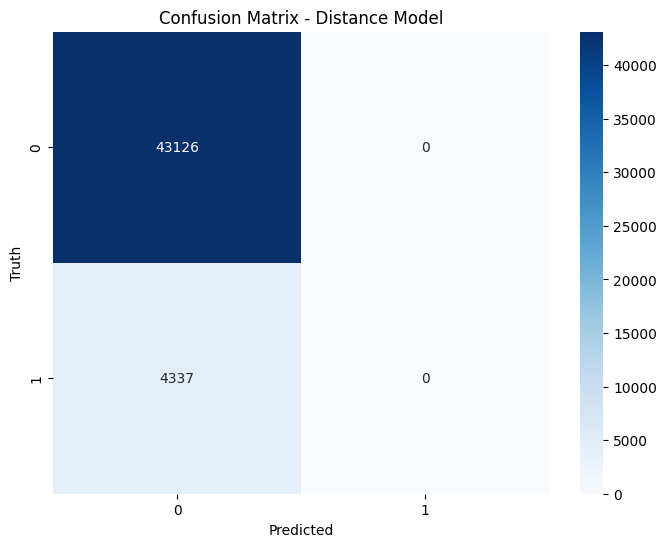

Distance Model Accuracy: 0.9086235594041675


In [29]:
# Confusion Matrix for Distance Model
print(confusion_matrix(y_val, y_pred_distance))
cm_distance = confusion_matrix(y_val, y_pred_distance)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_distance, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Matrix - Distance Model')
plt.savefig('conf_matrix_distance.png')
plt.show()

# Calculate the model's score
score_distance = clf_distance.score(X_val[['shot_distance_to_goal']], y_val)
print(f'Distance Model Accuracy: {score_distance}')


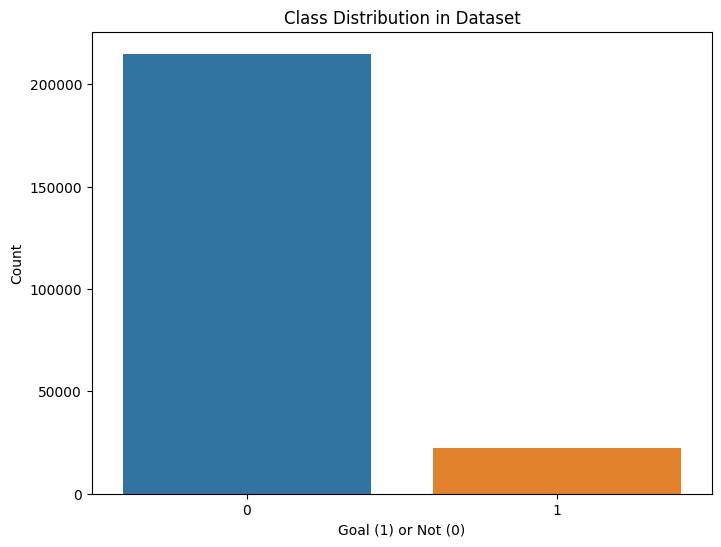

In [14]:
# Potential issue Imbalanced Classes
# Count the occurrences of each class (goal or not)
class_counts = y.value_counts()

# Create a bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.xlabel('Goal (1) or Not (0)')
plt.ylabel('Count')
plt.title('Class Distribution in Dataset')
plt.show()


Produce four figures (one curve per model per plot) to probe our model’s performance. Make sure you are using the probabilities obtained on the validation set:


In [15]:
def create_roc_curves(model_list, model_probs, valid_labels, file_name):
    plt.figure(figsize=(10, 6))
    line_width = 2
    for i, model in enumerate(model_list):
        false_positive_rate, true_positive_rate, _ = roc_curve(valid_labels.ravel(), model_probs[i].ravel())
        area_under_curve = auc(false_positive_rate, true_positive_rate)
        plt.plot(false_positive_rate, true_positive_rate, lw=line_width, label=f"Model {model} - AUC: {area_under_curve:.2f}")

    plt.plot([0, 1], [0, 1], color="grey", lw=line_width, linestyle='--', label="Baseline (Random)")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve Comparison")
    plt.legend(loc="lower right")
    plt.savefig(file_name)
    plt.show()


In [16]:
def generate_goal_rate_plot(model_names, binned_data, output_file):
    plt.figure(figsize=(10, 5))
    plt.title("Analysis of Goal Rate by Model")
    for i, model in enumerate(model_names):
        sns.lineplot(x='goal_perc_bins', y='goal_rate', data=binned_data[i], linewidth=2.5, label=model)
    plt.xlabel('Model Probability Percentile')
    plt.ylabel('Goal Rate')
    plt.xticks(np.arange(0, 120, 20))
    plt.legend(loc="best")
    plt.xlim(100, 0)
    plt.savefig(output_file)
    plt.show()


In [17]:
def visualize_cumulative_goals(model_names, binned_data, file_path):
    plt.figure(figsize=(10, 5))
    plt.title("Cumulative Goals Analysis")
    for i, model in enumerate(model_names):
        sns.lineplot(x='goal_perc_bins', y='goal_cumsum', data=binned_data[i], linewidth=2.5, label=model)
    plt.xlabel('Percentile of Model Predictions')
    plt.ylabel('Cumulative Goal Ratio')
    plt.xticks(np.arange(0, 120, 20))
    plt.legend(loc="lower right")
    plt.xlim(100, 0)
    plt.savefig(file_path)
    plt.show()


In [18]:
def plot_model_calibration(model_names, probability_data, save_as):
    plt.figure(figsize=(7, 7))
    plt.title("Model Calibration Performance")
    plt.plot([0, 1], [0, 1], linestyle=':', color="black", label="Ideal Calibration")
    for i, model in enumerate(model_names):
        fraction_of_positives, mean_predicted_value = calibration_curve(probability_data[i]['goal'], probability_data[i]['goal_Prob'] / 100, n_bins=20)
        plt.plot(mean_predicted_value, fraction_of_positives, marker='s', label=f"{model}")
    plt.xlabel('Average Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.xticks(np.arange(0, 1.1, 0.2))
    plt.yticks(np.arange(0, 1.1, 0.2))
    plt.legend(loc="best")
    plt.savefig(save_as)
    plt.show()


In [19]:
# Model names
model_names = ['Distance', 'Angle', 'Both Features', 'Random Baseline']

# Predicted probabilities from each model
model_probs = [predicted_prob_distance, predicted_prob_angle, predicted_prob_both, y_prob_random]

# Predictions from each model
model_preds = [y_pred_distance, y_pred_angle, y_pred_both, y_pred_random]


In [20]:
def prepare_data_for_plots(y_pred, y_prob, y_val):
    df = pd.DataFrame({
        'goal_pred': y_pred,
        'goal': y_val,
        'goal_Prob': y_prob * 100  # Converting probabilities to percentages
    })
    df['shot'] = 1  # Counting each prediction as a shot
    sum_goal = df['goal'].sum()
    df['percentile'] = df['goal_Prob'].rank(pct=True) * 100
    df['goal_perc_bins'] = pd.cut(df['percentile'], bins=np.arange(0, 105, 5), labels=np.arange(2.5, 100, 5))
    return df

# Create DataFrames for each model
df_distance = prepare_data_for_plots(y_pred_distance, predicted_prob_distance, y_val)
df_angle = prepare_data_for_plots(y_pred_angle, predicted_prob_angle, y_val)
df_both = prepare_data_for_plots(y_pred_both, predicted_prob_both, y_val)
df_random = prepare_data_for_plots(y_pred_random, y_prob_random, y_val)

In [21]:
def bin_data(df):
    binned = df.groupby(['goal_perc_bins']).agg({'shot': 'sum', 'goal': 'sum'}).reset_index()
    binned['goal_rate'] = binned['goal'] / binned['shot']
    binned['goal_cum'] = binned['goal'].cumsum()
    binned['goal_cumsum'] = 1 - (binned['goal_cum'] / binned['goal'].sum())
    return binned

# Bin data for each model
df_binned_distance = bin_data(df_distance)
df_binned_angle = bin_data(df_angle)
df_binned_both = bin_data(df_both)
df_binned_random = bin_data(df_random)

In [22]:
df_prob_list = [df_distance, df_angle, df_both, df_random]
df_prob_bined_list = [df_binned_distance, df_binned_angle, df_binned_both, df_binned_random]
df_prob_list

[        goal_pred  goal  goal_Prob  shot  percentile goal_perc_bins
 135752          0     0  15.463941     1   77.477193           77.5
 369480          0     0   6.730051     1   42.853381           42.5
 273900          0     0   9.892313     1   58.594063           57.5
 370661          0     0  19.017434     1   91.514443           92.5
 230909          0     0   0.819396     1    0.752165            2.5
 ...           ...   ...        ...   ...         ...            ...
 167992          0     0  14.707650     1   74.784569           72.5
 311333          0     0   9.173620     1   55.612793           57.5
 292433          0     0  18.758747     1   90.459937           92.5
 176464          0     0  19.238400     1   92.676401           92.5
 187320          0     0  21.373510     1   98.997114           97.5
 
 [47463 rows x 6 columns],
         goal_pred  goal  goal_Prob  shot  percentile goal_perc_bins
 135752          0     0   9.505395     1   49.584940           47.5
 3694

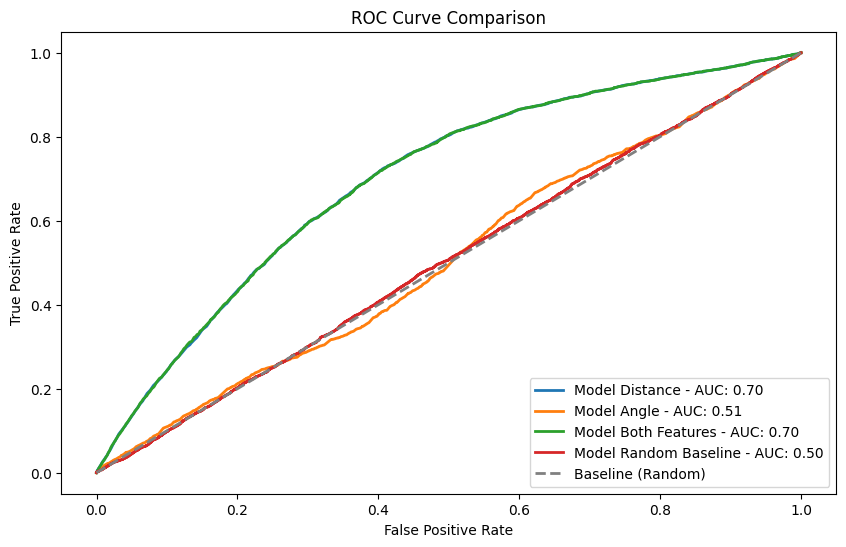

In [23]:
create_roc_curves(model_names, model_probs, y_val, 'roc_curve_plot.png')

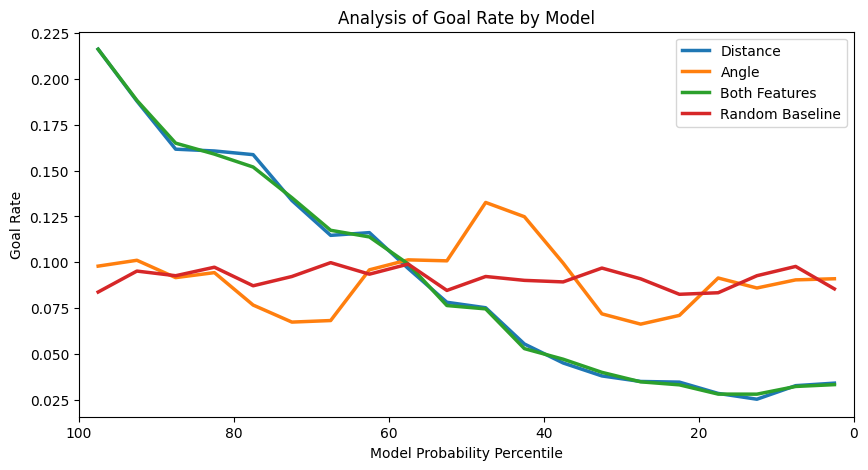

In [24]:
generate_goal_rate_plot(model_names, df_prob_bined_list, 'goal_rate_plot.png')

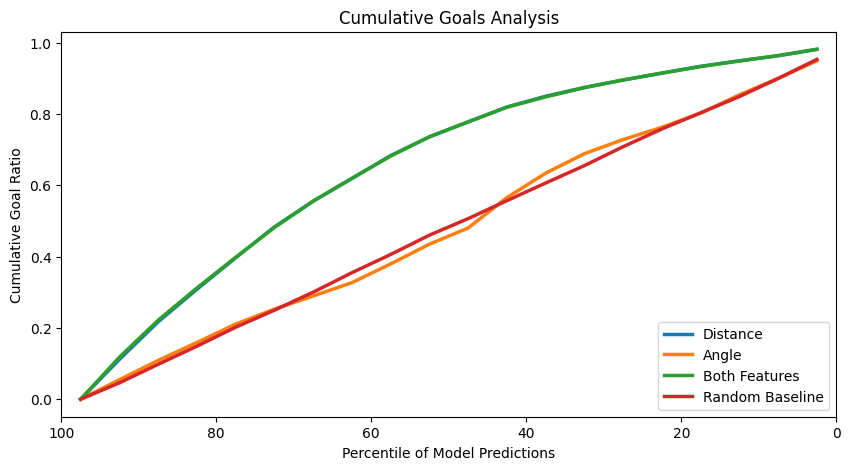

In [25]:
visualize_cumulative_goals(model_names, df_prob_bined_list, 'cumulative_goal_rate_plot.png')

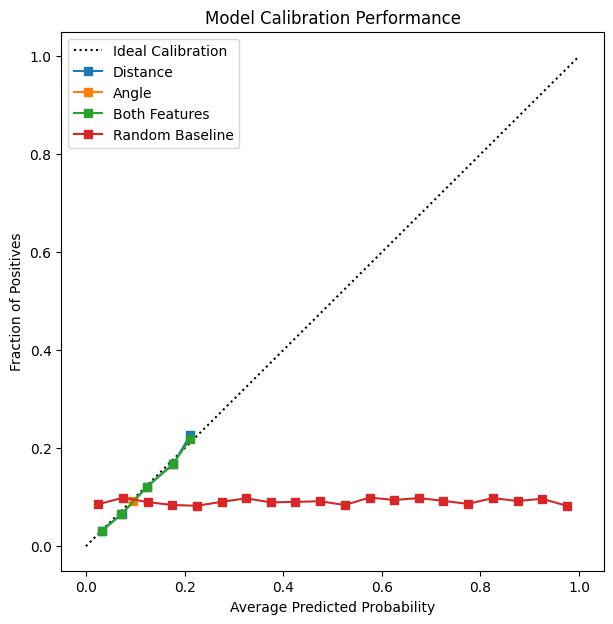

In [26]:
plot_model_calibration(model_names, df_prob_list, 'calibration_curve_plot.png')

In [27]:
# Log the ROC curve plot to Comet.ml
experiment.log_image('roc_curve_plot.png', name="ROC Curve", overwrite=False)

# Log the Goal Rate plot to Comet.ml
experiment.log_image('goal_rate_plot.png', name="Goal Rate", overwrite=False)

# Log the Cumulative Goal Rate plot to Comet.ml
experiment.log_image('cumulative_goal_rate_plot.png', name="Cumulative Goal Rate", overwrite=False)

# Log the Calibration Curve plot to Comet.ml
experiment.log_image('calibration_curve_plot.png', name="Calibration Curve", overwrite=False)


{'web': 'https://www.comet.com/api/image/download?imageId=89ff8459963e490ab5ab480ce0e4d2c5&experimentKey=916f8c382bc04495adeeef4cf15b98e9',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=89ff8459963e490ab5ab480ce0e4d2c5&experimentKey=916f8c382bc04495adeeef4cf15b98e9',
 'imageId': '89ff8459963e490ab5ab480ce0e4d2c5'}

In [28]:
experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/mahmoodhegazy/nhl-data-science/916f8c382bc04495adeeef4cf15b98e9
COMET INFO:   Parameters:
COMET INFO:     C                 : 1.0
COMET INFO:     class_weight      : None
COMET INFO:     dual              : False
COMET INFO:     fit_intercept     : True
COMET INFO:     intercept_scaling : 1
COMET INFO:     l1_ratio          : None
COMET INFO:     max_iter          : 100
COMET INFO:     multi_class       : auto
COMET INFO:     n_jobs            : None
COMET INFO:     penalty           : l2
COMET INFO:     random_state      : None
COMET INFO:     solver            : lbfgs
COMET INFO:     tol               : 0.0001
COMET INFO:     